In [72]:
import TMQGP as tm
from numpy import *
import QuarkTM
import numpy as np
from tqdm import notebook as tqdm

In [73]:
import matplotlib
matplotlib.style.use('publication23')

# Import spectral functions and T-matrices

In [74]:
folder = '../run/output/QuarkOnly_X_1ch_test4pi_onshell/'

In [75]:
trange = arange(0.2, 0.5, 0.05)

In [76]:
T = 0.2
qrange = np.loadtxt(folder + 'qrange_T=%.3f.dat'%T)
erange = np.loadtxt(folder + 'erange_T=%.3f.dat'%T)

In [77]:
pts = []

ch_names = ['qa1']#, 'qa8', 'qq3', 'qq6']

TMs = []
Xs = []
Sigmas = []
Sigma_tots = []

for T in trange:
    qrange = np.loadtxt(folder + 'qrange_T=%.3f.dat'%T)
    erange = np.loadtxt(folder + 'erange_T=%.3f.dat'%T)
    Gtab = np.loadtxt(folder + 'Q_G_T=%.3f.dat'%T, dtype=complex)
    
    Gtab = 1/(1/Gtab - 0*5e-2j)
    
    pt = QuarkTM.Particle(0.6, qrange, erange, 
                         Gtab=Gtab)
    pts += [pt]
    
    Sigma_tot = np.loadtxt(folder + 'Q_S_T=%.3f.dat'%T, dtype=complex)
    
    Sigma_tots += [Sigma_tot]
    
    tms = dict()
    sms = dict()
    xms = dict()
    for ch in ch_names:
#         print(ch)
        _tm = np.loadtxt(folder + f'Q_TM_{ch}_T=%.3f.dat'%T,
                       dtype=complex)
        
        _x = np.loadtxt(folder + f'Q_X_{ch}_T=%.3f.dat'%T,
                       dtype=complex)
        tms[ch] = _tm
        
#         sigma = np.loadtxt(folder + f'Q_ReS_{ch}_T=%.3f.dat'%T)
        sigma = (1j*np.loadtxt(folder + f'Q_ImS_{ch}_T=%.3f.dat'%T)
                + np.loadtxt(folder + f'Q_ReS_{ch}_T=%.3f.dat'%T))
        
        sms[ch] = sigma
        xms[ch] = _x
        
    Xs += [xms]
    TMs += [tms]
    Sigmas += [sms]

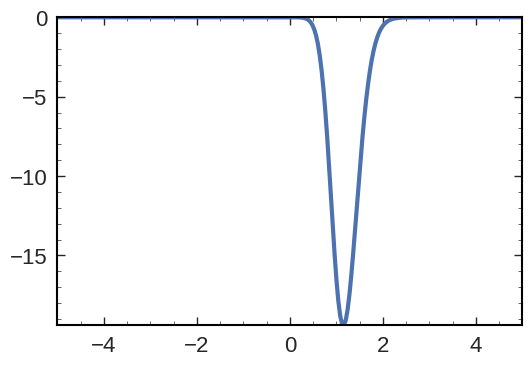

In [78]:
plt.plot(erange, imag(TMs[-1]['qa1'][:, 0]))

(-1.0, 2.0)

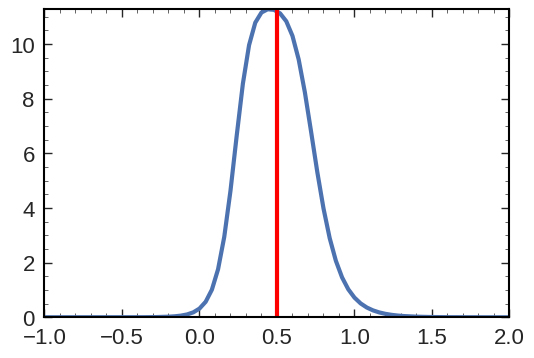

In [79]:
plt.plot(erange, -2*imag(pts[-1].Gtab[:, 0]))
plt.axvline(0.5, c='red')
plt.xlim(-1, 2)

(-2.0, 2.0)

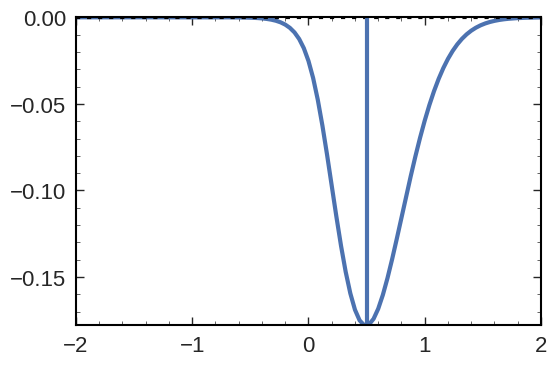

In [80]:
plt.plot(erange, imag(Sigma_tots[-1][:, 0]))
plt.axhline(0, ls=':', c='black')
plt.axvline(0.5)
plt.xlim(-2, 2)

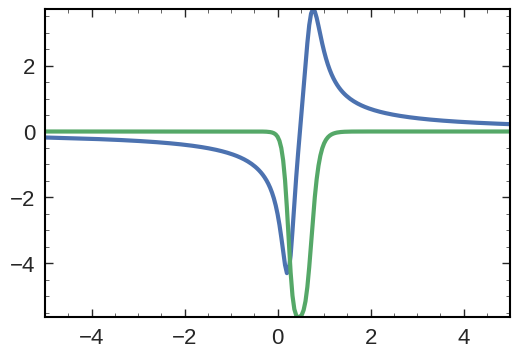

In [81]:
plt.plot(erange, real(pts[-1].Gtab[:, 0]))
plt.plot(erange, imag(pts[-1].Gtab[:, 0]))

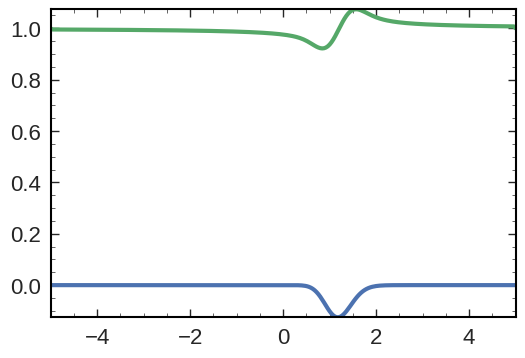

In [82]:
plt.plot(erange, imag(log(1-Xs[-1]['qa1'][:, 0])))
plt.plot(erange, real(1 - Xs[-1]['qa1'][:, 0]))

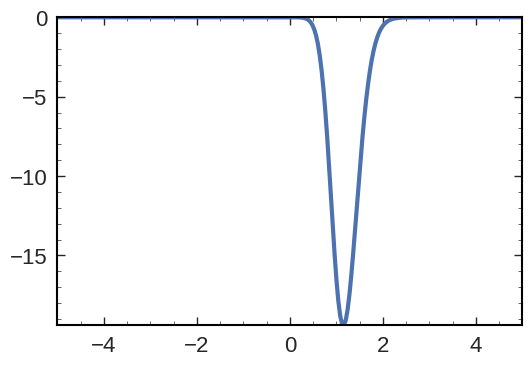

In [83]:
plt.plot(erange, imag(TMs[-1]['qa1'][:, 0]))

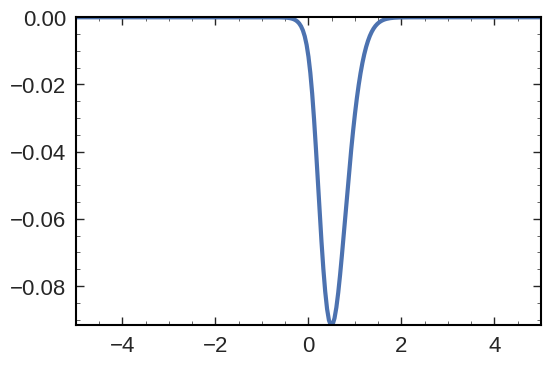

In [84]:
plt.plot(erange, imag(Sigmas[-1]['qa1'][:, 0]))

#  Pressure

## Calculate the quasiparticle pressure

In [85]:
ps_Q = array([tm.OmQ_F(T, pt.iImG, pt.iReG) 
            for T, pt in zip(trange, pts)])

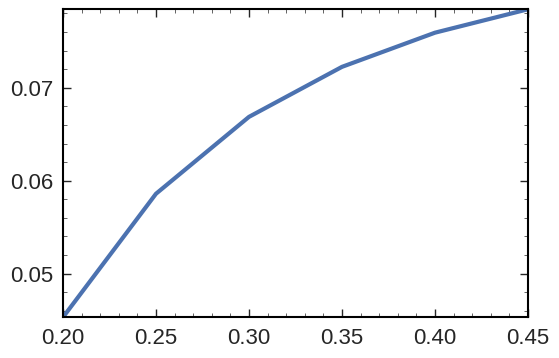

In [86]:
plt.plot(trange, ps_Q/trange**4)

## Calculate the self-energy pressure

In [87]:
import numpy as np

In [88]:
ps_S = []

ps_S2 = []

for T, pt, sms, sig_tot in zip(trange, pts, Sigmas, Sigma_tots):
#     sigma = np.sum(list(sms.values()), axis=0) - 1e-3j
    sigma = sig_tot
#     plt.plot(erange, real(sigma[:, 0]))
    iReS = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(real(sigma)))
    iImS = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(imag(sigma)))
    
    iImG = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(imag(pt.Gtab)))
    iReG = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(real(pt.Gtab)))
    
#     break
#     print(T)
    ps_S += [tm.OmS_F(T, iImG, iReG, iImS, iReS)]
#     ps_S2 += [tm.OmS2_F(T, iImG, iReG, iImS, iReS)]
    

In [89]:
ps_S2 = array(ps_S2)

In [90]:
tm.OmS_F(T, iImG, iReG, iImS, iReS)

9.856479256672689e-05

In [91]:
# tm.OmS2_F(T, iImG, iReG, iImS, iReS)

In [92]:
ps_S = array(ps_S)
ps_Q = array(ps_Q)

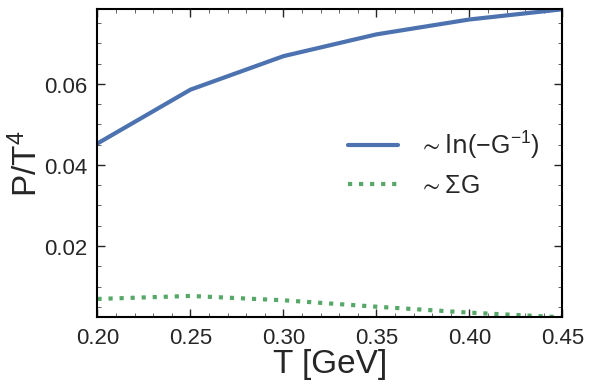

In [93]:
plt.plot(trange, ps_Q/trange**4, label='$\sim\ln(-G^{-1})$')
plt.plot(trange, ps_S/trange**4, ls=':', label='$\sim\Sigma G$')
plt.xlabel('T [GeV]')
plt.ylabel('$P/T^4$')
plt.legend()

Plot the integrand

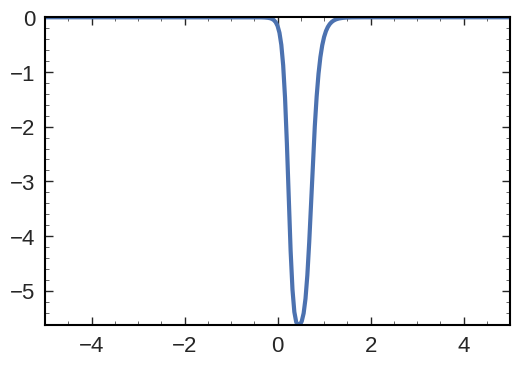

In [94]:
plt.plot(erange, [iImG(0, e) for e in erange])

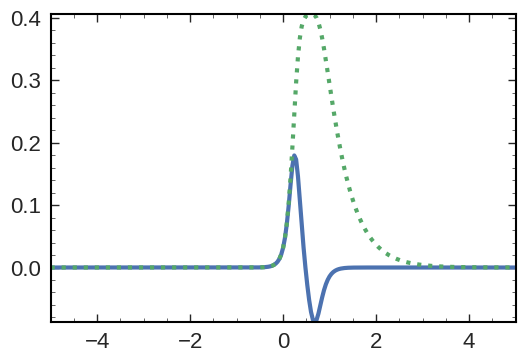

In [95]:
plt.plot(erange, [tm.n_f(e, T) * (iReG(0, e)*iImS(0, e)) for e in erange])
# plt.plot(erange, [tm.n_f(e, T) * (iImG(0, e)*iReS(0, e)) for e in erange])

plt.plot(erange, [tm.n_f(e, T) * tm.delta(e, 0, iImG, iReG) for e in erange], ls=':')


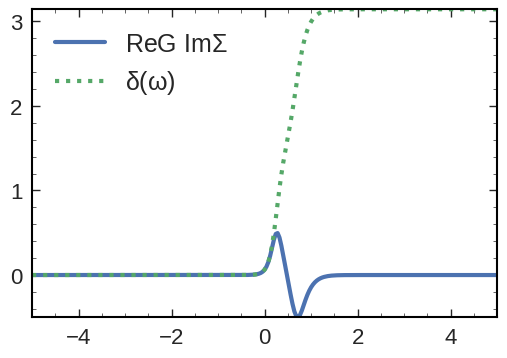

In [96]:
plt.plot(erange, [(iReG(0, e)*iImS(0, e)) for e in erange], label='ReG Im$\Sigma$')
plt.plot(erange, [tm.delta(e, 0, iImG, iReG) for e in erange], ls=':', label='$\delta(\omega)$')

plt.legend()


In [97]:
from scipy.integrate import quad

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


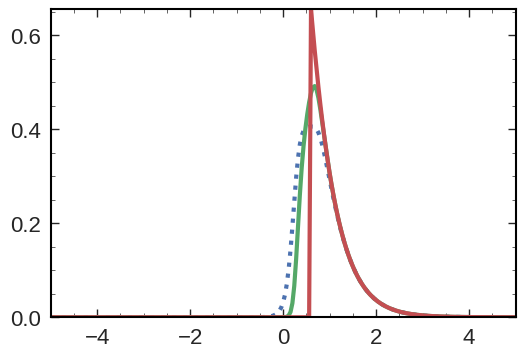

In [98]:
plt.plot(erange, [tm.n_f(e, T) * tm.delta(e, 0, iImG, iReG) for e in erange], ls=':')

plt.plot(erange, [tm.n_f(e, T) * tm.delta(e, 0, iImG, iReG) for e in erange] 
                    - array([tm.n_f(e, T) * (iReG(0, e)*iImS(0, e)) for e in erange]))

plt.plot(erange, [pi*tm.n_f(e, T) if e > 0.6 else 0 for e in erange])

plt.legend()



Get the QP masses

In [99]:
from scipy.integrate import quad

Pfree = array([quad(lambda z: z*z*T*log(1 + exp(-sqrt(0.6**2 + z**2)/T)) / 2/pi**2, 0, 5)[0] for T in trange])

In [100]:
ps_S

array([1.10884297e-05, 2.99632657e-05, 5.34812586e-05, 7.51903375e-05,
       9.08092581e-05, 9.85647926e-05])

In [101]:
ps_Q

array([7.25009488e-05, 2.28891490e-04, 5.41602008e-04, 1.08410113e-03,
       1.94348914e-03, 3.21633084e-03])

Text(0.5, 0, 'T [GeV]')

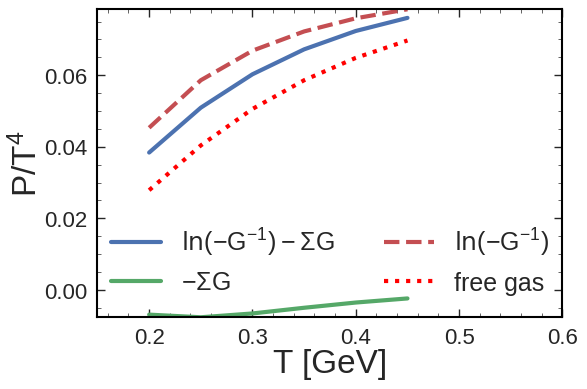

In [102]:
plt.plot(trange, (ps_Q - ps_S)/trange**4, label='$\ln(-G^{-1}) - \Sigma G$')
plt.plot(trange, (-ps_S)/trange**4, label='$-\Sigma G$')
plt.plot(trange, (ps_Q)/trange**4, ls='--', label='$\ln(-G^{-1})$')
plt.plot(trange, Pfree/trange**4, ls=':', c='red', label='free gas')

# plt.ylim(0, 0.2)
plt.xlim(0.15, 0.6)

plt.legend(ncol=2, loc='lower center')

plt.ylabel('$P/T^4$')
plt.xlabel('T [GeV]')

# plt.text(0.4, 0.6, r'$m_f$ = 0.6 GeV', fontsize=20)

# plt.savefig('PQ_lowres_attr_negrange.pdf', bbox_inches='tight')

Text(0.5, 0, 'T [GeV]')

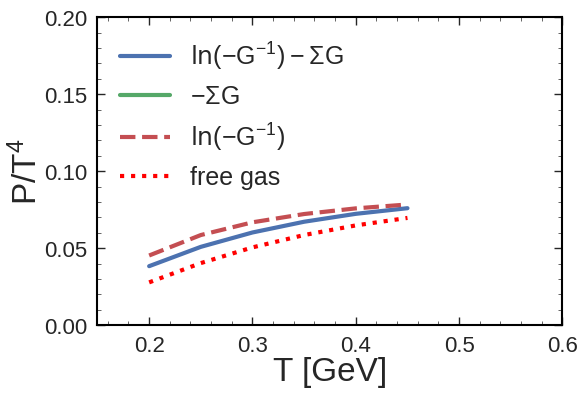

In [103]:
plt.plot(trange, (ps_Q - ps_S)/trange**4, label='$\ln(-G^{-1}) - \Sigma G$')
plt.plot(trange, (-ps_S)/trange**4, label='$-\Sigma G$')
plt.plot(trange, (ps_Q)/trange**4, ls='--', label='$\ln(-G^{-1})$')
plt.plot(trange, Pfree/trange**4, ls=':', c='red', label='free gas')

plt.ylim(0, 0.2)
plt.xlim(0.15, 0.6)

plt.legend(ncol=1, loc='upper left')

plt.ylabel('$P/T^4$')
plt.xlabel('T [GeV]')

# plt.text(0.4, 0.6, r'$m_f$ = 0.6 GeV', fontsize=20)

# plt.savefig('PQ_lowres_attr.pdf', bbox_inches='tight')

(0.0, 2.0)

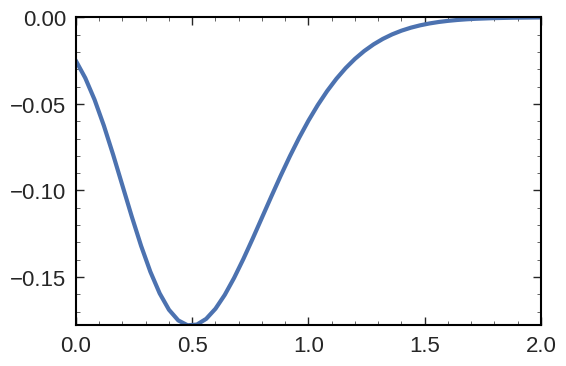

In [104]:
plt.plot(erange, imag(Sigma_tots[-1][:, 0]))
plt.xlim(0, 2)

## $\Phi$-functional

Total Log T:

In [105]:
len(Xs)

6

In [106]:
i = 0

xms = Xs[i]
tms = TMs[i]

In [126]:
LT = 0
TM = 0
LT0 = 0

for k, x in xms.items():
    ds, da, Fa = np.loadtxt(folder + f'{k}_weights')
    v = np.loadtxt(folder + f'{k}_vq.dat')
    LT += 4*pi*ds * da / 6 * v**2 / x * log(1 - x)
    LT0 += log(1-x)
    
for k, _tm in tms.items():
    ds, da, Fa = np.loadtxt(folder + f'{k}_weights')
    v = np.loadtxt(folder + f'{k}_vq.dat')
    TM += 4*pi*ds * da / 6 * _tm

Try to integrate this thing

In [108]:
iImLT = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(LT)))

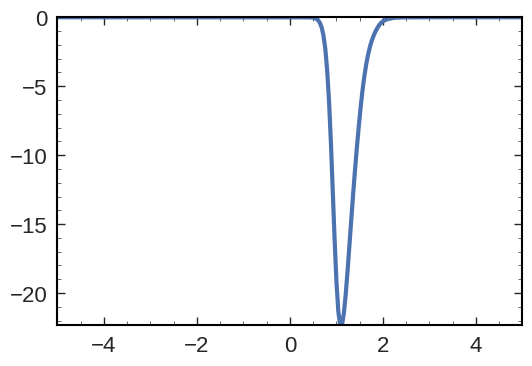

In [109]:
plt.plot(erange, imag(LT[:, 0]))

In [51]:
ST = array([[tm.sigma_ff(e, q, trange[i], iImLT, pts[i].R) for e in erange] for q in tqdm.tqdm(qrange)])

  0%|          | 0/51 [00:00<?, ?it/s]

(0.0, 2.0)

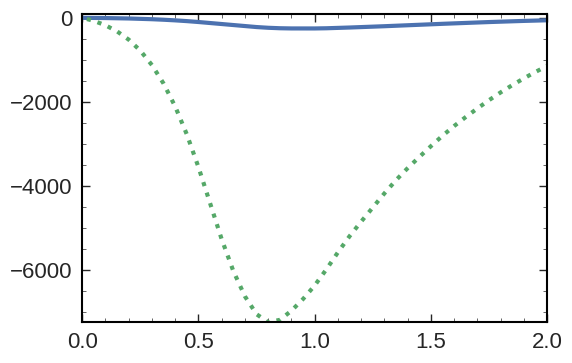

In [52]:
# plt.plot(erange, LT[:, 0])
plt.plot(erange, imag(LT[:, 0]))

# plt.plot(erange, TM[:, 0], ls=':')
plt.plot(erange, imag(TM[:, 0]), ls=':')

plt.xlim(0, 2)

In [53]:
ST = ST.transpose()

In [54]:
iImST = tm.Interpolator2D(qrange, erange, ascontiguousarray(ST))

In [55]:
ReST = []

for res in tqdm.tqdm(ST.transpose()):
    iImSigma = tm.Interpolator(erange, np.ascontiguousarray(res), 'cubic')
    ReSigma = [tm.ReSigmaKK(e, iImSigma) for e in erange]
    ReST += [ReSigma]

ReST = np.array(ReST).transpose()

  0%|          | 0/51 [00:00<?, ?it/s]

In [56]:
iReST = tm.Interpolator2D(qrange, erange, ascontiguousarray(ReST))

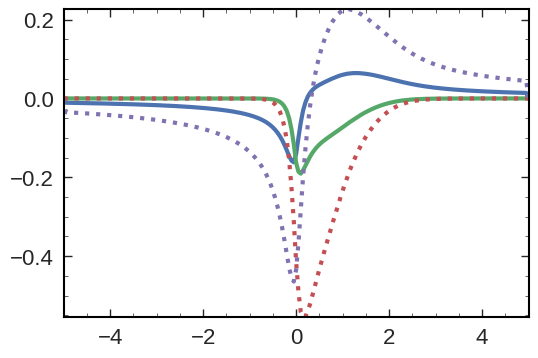

In [60]:
plt.plot(erange, ReST[:, 0])
plt.plot(erange, ST[:, 0])
plt.plot(erange, imag(Sigma_tots[i][:, 0]), ls=':')
plt.plot(erange, real(Sigma_tots[i][:, 0]), ls=':')

In [72]:
pt = pts[i]

In [73]:
Phi = 0.5 * tm.OmS_B(trange[i], pt.iImG, pt.iReG, iImST, iReST)
Phi

1.3601955248031926e-05

In [74]:
ps_Q[i] - ps_S[i]

5.2375863331615737e-05

In [66]:
integrand = array([tm.OmS_B_om_int(q, trange[i], pt.iImG, pt.iReG, iImST, iReST)
                  for q in qrange])

(0.0, 1.0)

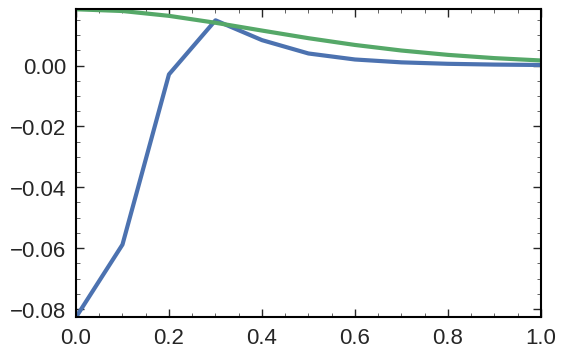

In [67]:
plt.plot(qrange, integrand)
plt.plot(qrange, 
        -log(1 - exp(-sqrt(0.8**2 + qrange**2) / trange[i])))
plt.xlim(0, 1)

Try to integrate with 2-particle GF

In [68]:
ch = QuarkTM.Channel(pt, pt, trange[i])

In [69]:
integrand2 = array([tm.OmS_B_om_int(q, trange[i], ch.iImG2, ch.iReG2, iImST, iReST)
                  for q in qrange])

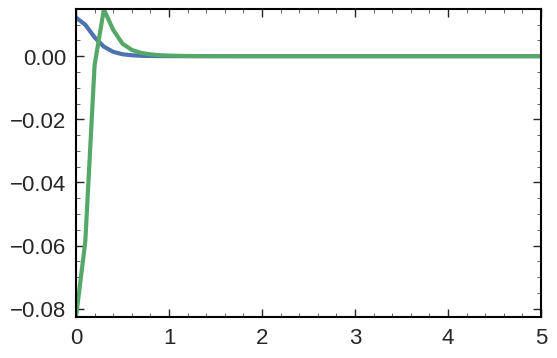

In [70]:
plt.plot(qrange, integrand2)
plt.plot(qrange, integrand)

### Try to iterate it

In [110]:
folder

'../run/output/QuarkOnly_X_1ch_test4pi_onshell/'

In [111]:
Phis = []

for i, T in enumerate(trange):
    xms = Xs[i]
    tms = TMs[i]

    LT = 0
    TM = 0

    for k, x in xms.items():
        ds, da, Fa = np.loadtxt(folder + f'{k}_weights')
        v = np.loadtxt(folder + f'{k}_vq.dat')
        LT += 4*pi*ds * da / 6 * v**2 / x * log(1 - x)

    for k, _tm in tms.items():
        ds, da, Fa = np.loadtxt(folder + f'{k}_weights')
        v = np.loadtxt(folder + f'{k}_vq.dat')
        TM += ds * da / 6 * _tm

    iImLT = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(LT)))

    ST = array([[tm.sigma_ff(e, q, trange[i], iImLT, pts[i].R) for e in erange] for q in tqdm.tqdm(qrange)])

    ST = ST.transpose()

    iImST = tm.Interpolator2D(qrange, erange, ascontiguousarray(ST))

    ReST = []

    for res in tqdm.tqdm(ST.transpose()):
        iImSigma = tm.Interpolator(erange, np.ascontiguousarray(res), 'cubic')
        ReSigma = [tm.ReSigmaKK(e, iImSigma) for e in erange]
        ReST += [ReSigma]

    ReST = np.array(ReST).transpose()

    iReST = tm.Interpolator2D(qrange, erange, ascontiguousarray(ReST))

    pt = pts[i]

    Phi = 0.5 * tm.OmS_B(trange[i], pt.iImG, pt.iReG, iImST, iReST)
    Phis += [Phi]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

In [37]:
Phis_fake = []

for i, T in enumerate(trange):
    xms = Xs[i]
    tms = TMs[i]

    LT = 0
    TM = 0

    for k, x in xms.items():
        ds, da, Fa = np.loadtxt(folder + f'{k}_weights')
        v = np.loadtxt(folder + f'{k}_vq.dat')
        LT += ds * da / 6 * v**2 / x * log(1 - x)

    for k, _tm in tms.items():
        ds, da, Fa = np.loadtxt(folder + f'{k}_weights')
        v = np.loadtxt(folder + f'{k}_vq.dat')
        TM += ds * da / 6 * _tm

    iImLT = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(LT)))

#     ST = array([[tm.sigma_ff(e, q, trange[i], iImLT, pts[i].R) for e in erange] for q in tqdm.tqdm(qrange)])
    ST = imag(Sigma_tots[i])
#     ST = ST.transpose()

    iImST = tm.Interpolator2D(qrange, erange, ascontiguousarray(ST))

    ReST = []

    for res in tqdm.tqdm(ST.transpose()):
        iImSigma = tm.Interpolator(erange, np.ascontiguousarray(res), 'cubic')
        ReSigma = [tm.ReSigmaKK(e, iImSigma) for e in erange]
        ReST += [ReSigma]

    ReST = np.array(ReST).transpose()

    iReST = tm.Interpolator2D(qrange, erange, ascontiguousarray(ReST))

    pt = pts[i]

    Phi = 0.5 * tm.OmS_B(trange[i], pt.iImG, pt.iReG, iImST, iReST)
    Phis_fake += [Phi]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [112]:
Phis = np.array(Phis)

In [113]:
Phis

array([5.48151584e-07, 1.77959354e-06, 3.75851470e-06, 6.28907014e-06,
       9.14878801e-06, 1.21145754e-05])

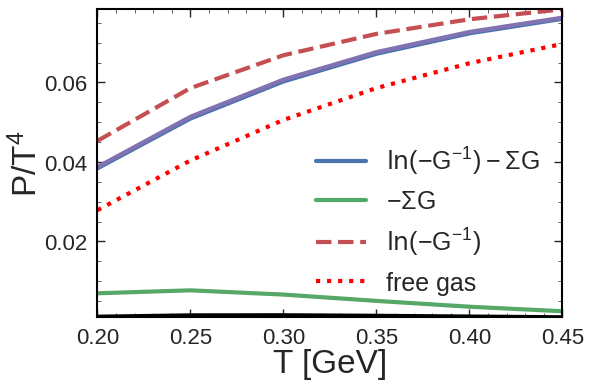

In [127]:
plt.plot(trange, 3*Phis/trange**4, c='black')

plt.plot(trange, (ps_Q - ps_S)/trange**4, label='$\ln(-G^{-1}) - \Sigma G$')
plt.plot(trange, (ps_S)/trange**4, label='$-\Sigma G$')
plt.plot(trange, (ps_Q)/trange**4, ls='--', label='$\ln(-G^{-1})$')
plt.plot(trange, Pfree/trange**4, ls=':', c='red', label='free gas')

# plt.ylim(0, 0.2)
# plt.xlim(0.15, 0.6)

plt.legend(ncol=1, loc=0)

plt.ylabel('$P/T^4$')
plt.xlabel('T [GeV]')

plt.plot(trange, (ps_Q - ps_S + Phis)/trange**4)
# plt.text(0.4, 0.6, r'$m_f$ = 0.6 GeV', fontsize=20)


# plt.ylim(0, 0.1)
# plt.savefig('PQ_lowres_attr.pdf', bbox_inches='tight')

# Try integration over coupling

In [83]:
l_range = linspace(0.2, 1, 12, endpoint=1)

In [224]:
integrands = []
for l in l_range:
    folder = '../run/output/QuarkOnly_X_1ch_lambda_dense/lambda=%.3f/'%l
    folder0 = '../run/output/QuarkOnly_X_1ch_lambda_dense/lambda=1.000/'

#     trange = arange(0.2, 0.6, 0.05)

    T = 0.2
    qrange = np.loadtxt(folder + 'qrange_T=%.3f.dat'%T)
    erange = np.loadtxt(folder + 'erange_T=%.3f.dat'%T)

    pts = []
    pts0 = []
    ch_names = ['qa1']#, 'qa8', 'qq3', 'qq6']

    TMs = []
    Xs = []
    Sigmas = []
    Sigma_tots = []

    for T in trange:
        qrange = np.loadtxt(folder + 'qrange_T=%.3f.dat'%T)
        erange = np.loadtxt(folder + 'erange_T=%.3f.dat'%T)
        Gtab = np.loadtxt(folder + 'Q_G_T=%.3f.dat'%T, dtype=complex)
        Gtab0 = np.loadtxt(folder0 + 'Q_G_T=%.3f.dat'%T, dtype=complex)

        Gtab = 1/(1/Gtab - 5e-2j)
        
        Gtab0 = 1/(1/Gtab0 - 5e-2j)

        pt = QuarkTM.Particle(0.5, qrange, erange, 
                             Gtab=Gtab)
        pt0 = QuarkTM.Particle(0.5, qrange, erange, 
                             Gtab=Gtab0)
        pts += [pt]
        pts0 += [pt0]

        Sigma_tot = np.loadtxt(folder + 'Q_S_T=%.3f.dat'%T, dtype=complex)

        Sigma_tots += [Sigma_tot]

        tms = dict()
        sms = dict()
        xms = dict()
        for ch in ch_names:
            print(ch)
            _tm = np.loadtxt(folder + f'Q_TM_{ch}_T=%.3f.dat'%T,
                           dtype=complex)

            _x = np.loadtxt(folder + f'Q_X_{ch}_T=%.3f.dat'%T,
                           dtype=complex)
            tms[ch] = _tm

    #         sigma = np.loadtxt(folder + f'Q_ReS_{ch}_T=%.3f.dat'%T)
            sigma = (1j*np.loadtxt(folder + f'Q_ImS_{ch}_T=%.3f.dat'%T)
                    + np.loadtxt(folder + f'Q_ReS_{ch}_T=%.3f.dat'%T))

            sms[ch] = sigma
            xms[ch] = _x

        Xs += [xms]
        TMs += [tms]
        Sigmas += [sms]

    ps_S = []

    for T, pt, sms, sig_tot in zip(trange, pts0, Sigmas, Sigma_tots):
    #     sigma = np.sum(list(sms.values()), axis=0) - 1e-3j
        sigma = sig_tot
    #     plt.plot(erange, real(sigma[:, 0]))
        iReS = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(real(sigma)))
        iImS = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(imag(sigma)))

        iImG = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(imag(pt.Gtab)))
        iReG = tm.Interpolator2D(qrange, erange, np.ascontiguousarray(real(pt.Gtab)))

    #     break
        ps_S += [tm.OmS_F(T, iImG, iReG, iImS, iReS)]
        
    integrands += [ps_S]

qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1
qa1


In [225]:
integrands = array(integrands)

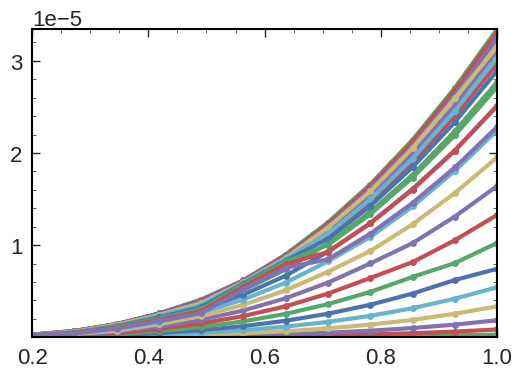

In [226]:
pss = []

for i in integrands.transpose():
    plt.plot(l_range, i/l_range, marker='.')
    pss += [trapz(i/l_range, x=l_range)]

In [227]:
pss = array(pss)

Text(0, 0.5, '$P/T^4$')

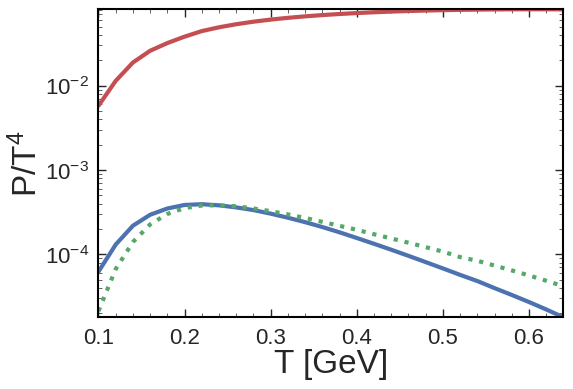

In [233]:
plt.plot(trange, pss/trange**4/2)
plt.plot(trange, Phis/trange**4, ls=':')

plt.semilogy(trange, (ps_Q - ps_S)/trange**4)
plt.xlabel('T [GeV]')
plt.ylabel('$P/T^4$')

Text(0, 0.5, '$P/T^4$')

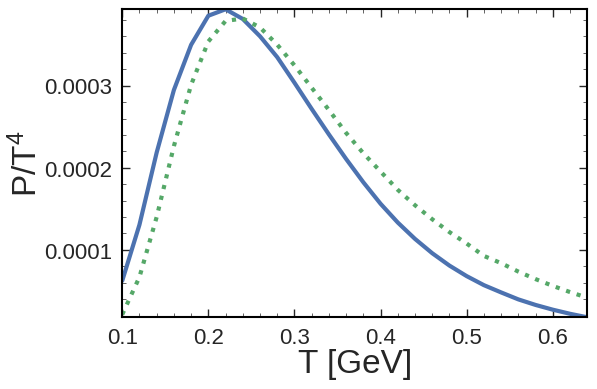

In [234]:
plt.plot(trange, pss/trange**4/2)
plt.plot(trange, Phis/trange**4, ls=':')

plt.xlabel('T [GeV]')
plt.ylabel('$P/T^4$')

# Compare with 1-resonance thing

Find the masses of resonance in my channel

In [107]:
len(TMs)

9

In [94]:
from scipy import optimize

[0.86666666]
[0.93333332]
[0.99999999]
[1.03333333]
[1.09999999]
[1.13333333]
[1.13333333]
[1.13333333]
[0.7]


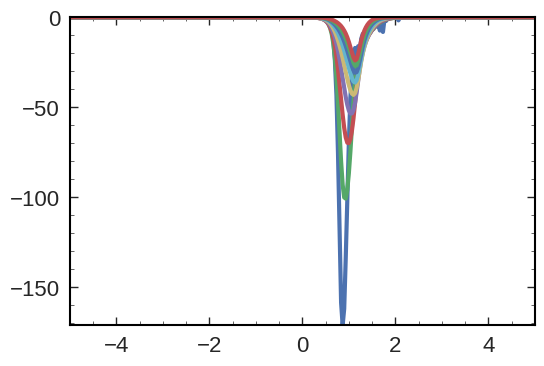

In [110]:
mss = []

for TM in TMs:
    _tm = TM['qa1']
#     plt.plot(erange, imag(_tm[:, 0]))
    iTM = interp1d(erange, imag(_tm[:, 0]))
    
    plt.plot(erange, imag(_tm[:, 0]))
    m_res = optimize.minimize(lambda z: iTM(z), 0.7)
    
    print(m_res.x)    
    mss += [m_res.x]

In [114]:
_tm = TMs[0]['qa1']

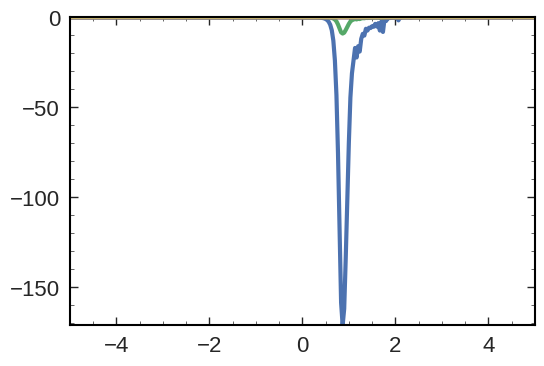

In [123]:
plt.plot(erange, imag(_tm[:, ::10]))

In [124]:
from scipy.integrate import quad

P_res = array([quad(lambda z: -z*z*T*log(1 - exp(-sqrt(0.87**2 + z**2)/T)) / 2/pi**2, 0, 5)[0] for mres, T in zip(mss, trange)])

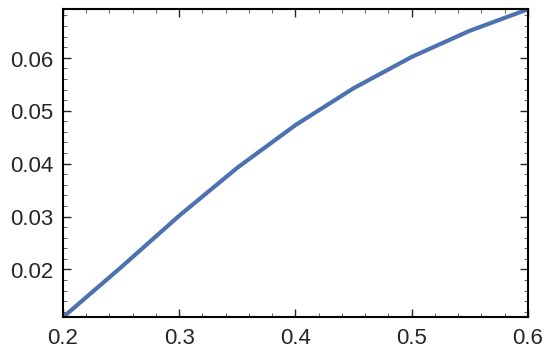

In [125]:
plt.plot(trange, P_res/trange**4)